# Метрики 
метрики для машинного обучения

## 1) Регрессия

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay)

import torch
from torchmetrics import MeanAbsoluteError, MeanSquaredError, R2Score

#### Кастомные реализации

In [2]:
import torch

def mse_custom(preds, targets):
    return torch.mean((preds - targets) ** 2)

def rmse_custom(preds, targets):
    return torch.sqrt(mse_custom(preds, targets))

def mae_custom(preds, targets):
    return torch.mean(torch.abs(preds - targets))

def r2_score_custom(preds, targets):
    ss_res = torch.sum((targets - preds) ** 2)
    ss_tot = torch.sum((targets - torch.mean(targets)) ** 2)
    return 1 - ss_res / ss_tot


In [3]:
# 1. Создание синтетических данных с помощью sklearn
X, y, coef = make_regression(
    n_samples=100,      # количество примеров
    n_features=1,       # число признаков
    noise=20,           # уровень шума
    bias=10,            # смещение (константа)
    coef=True,          # возвращать коэффициенты
    random_state=42
)


# 2. Сдвигаем target y, чтобы все значения были >= 0 (для MSLE)
y = y - y.min() + 1  # добавляем, чтобы минимум стал равен 1

# 2. Обучение простой линейной регрессии
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

In [4]:
targets = torch.from_numpy(y)
preds = torch.from_numpy(y_pred)


print("MSE:", mse_custom(preds, targets).item())
print("RMSE:", rmse_custom(preds, targets).item())
print("MAE:", mae_custom(preds, targets).item())
print("R²:", r2_score_custom(preds, targets).item())


MSE: 312.2170016849561
RMSE: 17.669663315551773
MAE: 14.208986262827834
R²: 0.853154207317982


#### Готовые

### 1. Mean Squared Error (MSE) — средняя квадратичная ошибка

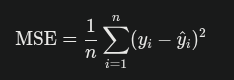

Графически: на диаграмме рассеяния с линией регрессии квадраты вертикальных отклонений от линии показывают вклад каждой точки в MSE

In [5]:

mse = mean_squared_error(y, y_pred)
print(f"Mean Squared Error (sklearn): {mse:.4f}")

mse_torch = MeanSquaredError()
print(f"MSE torch: {mse_torch(preds, targets).item():.4f}")

Mean Squared Error (sklearn): 312.2170
MSE torch: 312.2170


### 2. Mean Absolute Error (MAE) — средняя абсолютная ошибка  
Среднее абсолютное отклонение предсказаний от фактических значений:

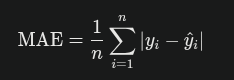  

Эта метрика более устойчива к выбросам, чем MSE.  
На графике видно, что для одинаковых точек отклонение измеряется как прямая вертикальная длина между точкой и линией предсказания

In [6]:
mae = mean_absolute_error(y, y_pred)
print(f"Mean Absolute Error (sklearn): {mae:.4f}")

mae_torch = MeanAbsoluteError()
print(f"MAE torch: {mae_torch(preds, targets).item():.4f}")

Mean Absolute Error (sklearn): 14.2090
MAE torch: 14.2090


### 3. MedAE - Median Absolute Error

Похожа на MAE, но считает разницу не со средним, а с медианой, поэтому если в датасете есть выбросы - она менее чуствительна к ним

$MedAE = median(|y_1 - \hat{y}_1|, ..., |y_n - \hat{y}_n|)$

In [7]:
print("MedAE = ", median_absolute_error(y, y_pred))

MedAE =  12.833495436117985


### 4. Root Mean Squared Error (RMSE) — корень из MSE

возвращая ошибку в тех же единицах, что и целевая переменная, что облегчает интерпретацию

In [8]:
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Root Mean Squared Error (RMSE): 17.67


### 5. Коэффициент детерминации (R²) — показатель объясненной дисперсии

Показывает, какую долю дисперсии зависимой переменной объясняет модель:   

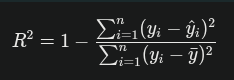 

Значения варьируются от −∞ до 1. Чем ближе к 1, тем лучше модель объясняет данные.

Графически — чем плотнее точки располагаются вокруг линии регрессии, тем выше R².

In [9]:
r2 = r2_score(y, y_pred)
print(f"R-squared (sklearn): {r2:.4f}")


r2 = R2Score()
print(f"R² torch: {r2(preds, targets).item():.4f}")

R-squared (sklearn): 0.8532
R² torch: 0.8532


### 6. RMSELE - Root Mean Squared Log Error

Похож на RMSE, но считается через логарифм, что позволяет использовать его для предсказаний признака в **бОльшем** диапазоне, чем MSE

$RMSLE = \sqrt{\frac{1}{n}\sum^{n}_{i=1}((\log{\hat{y}_i + 1}) - (\log{y_i + 1}))^2}$  

Не работает с отрицательными значениями из-за логарифма

In [10]:
msle = mean_squared_log_error(y, y_pred)
print(f"Mean Squared Logarithmic Error: {msle:.4f}")


rmsle = np.sqrt(mean_squared_log_error(y , y_pred))
print(f"Root Mean Squared Logarithmic Error: {rmsle:.4f}")

Mean Squared Logarithmic Error: 0.0404
Root Mean Squared Logarithmic Error: 0.2009


### 7. MAPE - Mean Absolute Percentage Error

Похожа на MAE но считает в процентах, насколько возникла ошибка. Используется если нужно предсказать проценты, и среднее отлично от нуля.

$MAPE = \frac{1}{n}\sum_{i=1}^n|\frac{y_i - \hat{y}_i}{y_i}|\times100\%$

In [11]:
mape1 = mape(y , y_pred)

print(f"MAPE: {mape1:.2f}")

MAPE: 0.18


### 8. SMAPE - Symmetric Mean Absolute Percentage Error

Если попадаются нулевые значения - лучше ее, MAPE с нулями не работает.

$SMAPE = \frac{100\%}{n}\sum_{i=1}^n2\cdot\frac{|y_i - \hat{y}_i|}{|y_i| + |\hat{y}_i|}$

In [12]:
def smape(d, p):
    return 100/len(d) * np.sum(2 * np.abs(p - d) / (np.abs(d) + np.abs(p)))

smape(y , y_pred)

np.float64(13.389052008848074)

### Визуализации

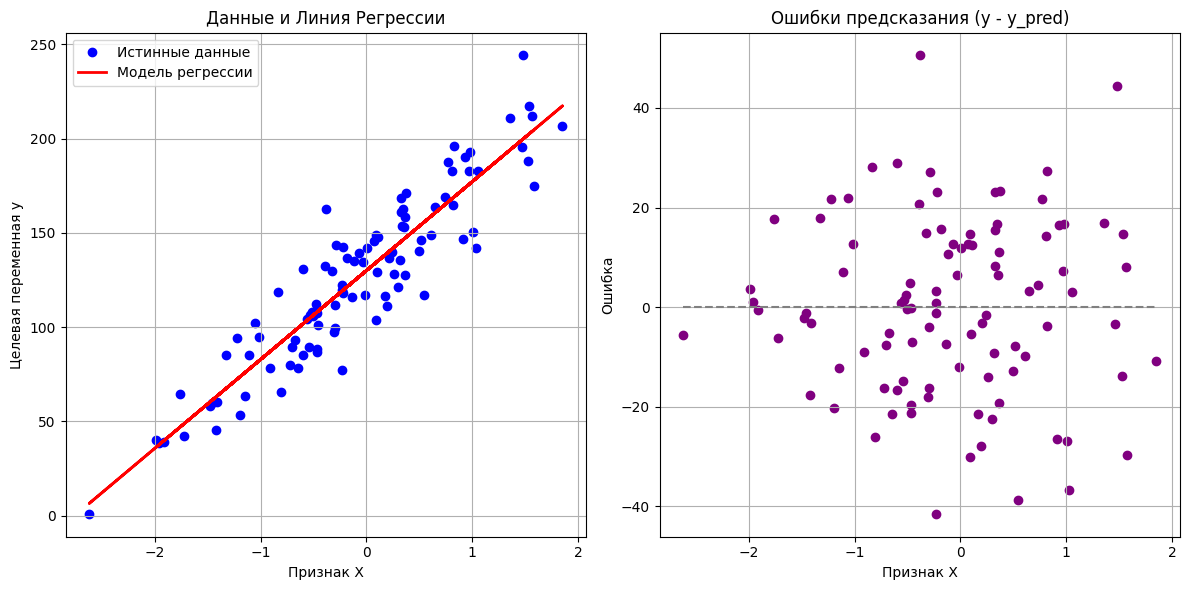

In [13]:

# 4. Визуализация данных и предсказаний
plt.figure(figsize=(12, 6))

# График: Истинные значения и линия регрессии
plt.subplot(1, 2, 1)
plt.scatter(X, y, color='blue', label='Истинные данные')
plt.plot(X, y_pred, color='red', linewidth=2, label='Модель регрессии')
plt.title('Данные и Линия Регрессии')
plt.xlabel('Признак X')
plt.ylabel('Целевая переменная y')
plt.legend()
plt.grid(True)

# График: Ошибки предсказания
plt.subplot(1, 2, 2)
errors = y - y_pred
plt.scatter(X, errors, color='purple')
plt.hlines(0, X.min(), X.max(), colors='gray', linestyles='dashed')
plt.title('Ошибки предсказания (y - y_pred)')
plt.xlabel('Признак X')
plt.ylabel('Ошибка')
plt.grid(True)

plt.tight_layout()
plt.show()


## 2) Классификация


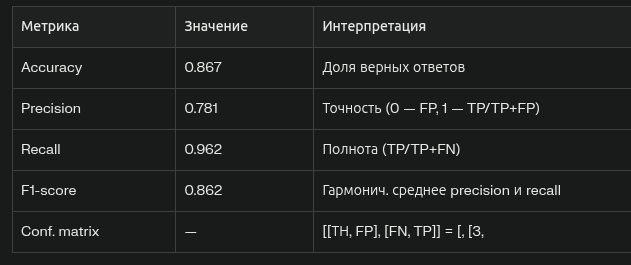  

In [14]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import torch
from torchmetrics import Accuracy, Precision, Recall, F1Score, ConfusionMatrix, AUROC

In [15]:
# Шаг 1: Генерация синтетических данных
X, y = make_classification(n_samples=200, n_features=2, n_redundant=0, n_informative=2,
                           n_clusters_per_class=1, weights=[0.5, 0.5], random_state=42)

# Шаг 2: Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Шаг 3: Обучение модели
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


targets = torch.from_numpy(y_test)
preds = torch.from_numpy(y_pred)

###  1. accuracy  
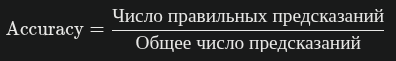

In [16]:
# Кастомная
def accuracy_custom(preds, targets):
    correct = (preds == targets).sum().item()
    total = targets.size(0)
    return correct / total

accuracy = accuracy_custom(preds, targets)
print(f'Accuracy custom:  {accuracy:.3f}')

# Готовая
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy sklearn:  {accuracy:.3f}')

accuracy = Accuracy(task="binary")
acc = accuracy(preds, targets)
print(f"Accuracy torch: {acc.item():.4f}")

Accuracy custom:  0.867
Accuracy sklearn:  0.867
Accuracy torch: 0.8667


In [17]:
# Многоклассовая
accuracy_multiclass = Accuracy(task="multiclass", num_classes=5)  # для задачи с 5 классами
acc = accuracy_multiclass(preds, targets)
print(f"Accuracy torch: {acc.item():.4f}")

Accuracy torch: 0.8667


### 2. precision
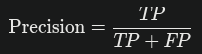

In [18]:
# Кастомная
def precision_custom(targets, preds):
    TP = ((preds == 1) & (targets == 1)).sum().item()
    FP = ((preds == 1) & (targets == 0)).sum().item()
    return TP / (TP + FP) if TP + FP > 0 else 0

precision = precision_custom(targets, preds)
print(f'Precision custom: {precision:.3f}')

# Готовая
precision = precision_score(y_test, y_pred)
print(f'Precision sklearn: {precision:.3f}')

precision = Precision(task="binary")
prec = precision(preds, targets)
print(f"Precision torch: {prec.item():.4f}")

Precision custom: 0.781
Precision sklearn: 0.781
Precision torch: 0.7812


In [19]:
## Для многоклассовой (например 5 классов)
precision_multi = Precision(task="multiclass", num_classes=5)
prec = precision_multi(preds, targets)
print(f"Precision torch: {prec.item():.4f}")

Precision torch: 0.8667


### 3. recall
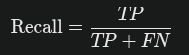

In [20]:
# Кастомная
def recall_custom(targets, preds):
    TP = ((preds == 1) & (targets == 1)).sum().item()
    FN = ((preds == 0) & (targets == 1)).sum().item()
    return TP / (TP + FN) if TP + FN > 0 else 0

recall = recall_custom(targets, preds)
print(f'Recall custom:    {recall:.4f}')

# Готовая
recall = recall_score(y_test, y_pred)
print(f'Recall sklearn:    {recall:.4f}')

recall = Recall(task="binary")
rec = recall(preds, targets)
print(f"Recall torch: {rec.item():.4f}")

Recall custom:    0.9615
Recall sklearn:    0.9615
Recall torch: 0.9615


In [21]:
# Для многоклассовой (например 5 классов)
recall_multi = Recall(task="multiclass", num_classes=5)
rec2 = recall_multi(preds, targets)
print(f"Recall torch: {rec2.item():.4f}")

Recall torch: 0.8667


### 4.  F1-score
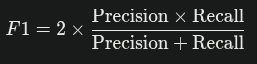

In [22]:
# Кастомная
def f1_score_custom(targets, preds):
    p = precision_custom(targets, preds)
    r = recall_custom(targets, preds)
    return 2 * p * r / (p + r) if (p + r) > 0 else 0


f1 = f1_score_custom(targets, preds)
print(f'F1-score custom:  {f1:.4f}')
          
# Готовая
f1 = f1_score(y_test, y_pred)
print(f'F1-score sklearn:  {f1:.4f}')

f1 = F1Score(task="binary")
f1_scor = f1(preds, targets)
print(f"F1 Score torch: {f1_scor.item():.4f}")

F1-score custom:  0.8621
F1-score sklearn:  0.8621
F1 Score torch: 0.8621


In [23]:
# Для многоклассовой (например 5 классов)
f1_multi = F1Score(task="multiclass", num_classes=5)
f1_multi(preds, targets)

tensor(0.8667)

### Confusion matrix
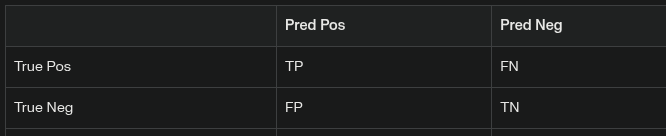

In [24]:
# Кастомная
def confusion_matrix_custom(targets, preds):
    TP = ((preds == 0) & (targets == 0)).sum().item()
    TN = ((preds == 1) & (targets == 1)).sum().item()
    FP = ((preds == 0) & (targets == 1)).sum().item()
    FN = ((preds == 1) & (targets == 0)).sum().item()
    return {'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN}


cm = confusion_matrix_custom(targets, preds)
print('Confusion matrix custom:\n', cm)

# Готовая
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix sklearn:\n', cm)

confmat = ConfusionMatrix(task="binary")
cm = confmat(preds, targets)
print(f"Confusion Matrix torch:\n{cm}")

Confusion matrix custom:
 {'TP': 27, 'TN': 25, 'FP': 1, 'FN': 7}
Confusion matrix sklearn:
 [[27  7]
 [ 1 25]]
Confusion Matrix torch:
tensor([[27,  7],
        [ 1, 25]])


ROC AUC torch: 0.9231
Accuracy:  0.867
Precision: 0.781
Recall:    0.962
F1-score:  0.862


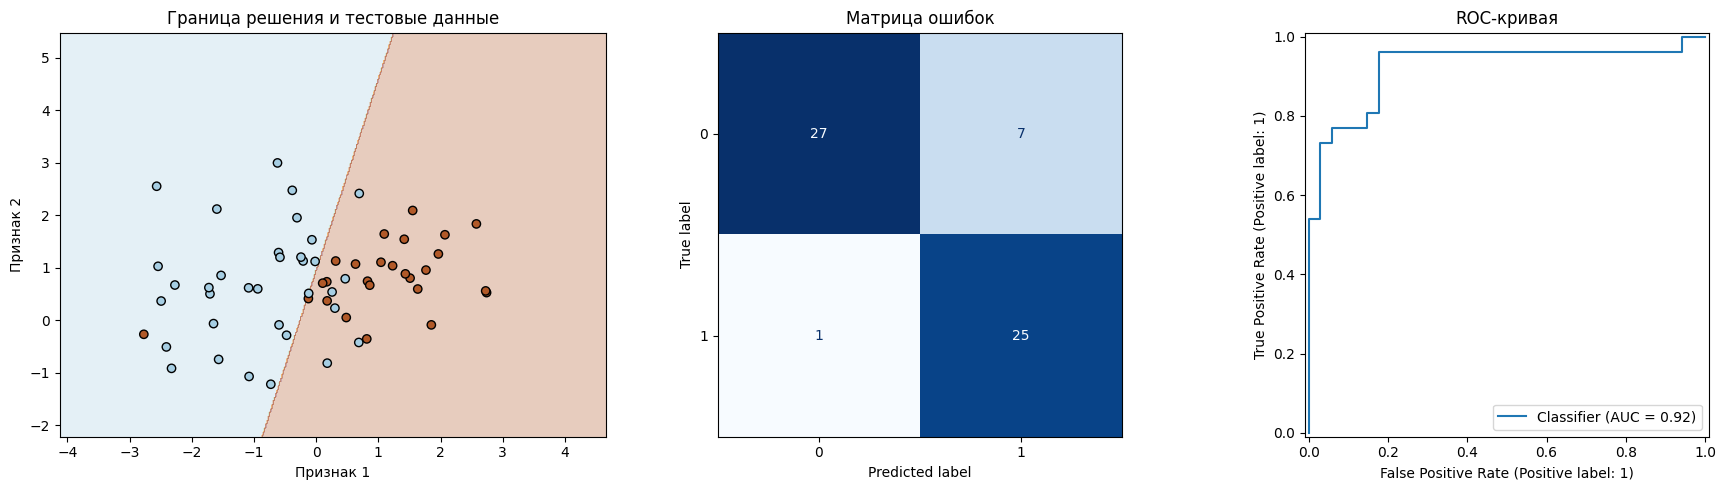

In [25]:

y_proba = model.predict_proba(X_test)[:, 1]  # вероятности класса 1 для ROC


targets = torch.from_numpy(y_test)
preds_prob = torch.from_numpy(y_proba)

# ROC AUC (нужны вероятности, для примера используем float тензор)
auroc = AUROC(task="binary")
roc_auc = auroc(preds_prob, targets)
print(f"ROC AUC torch: {roc_auc.item():.4f}")

# 4. Считаем метрики
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy:  {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall:    {recall:.3f}')
print(f'F1-score:  {f1:.3f}')

# 5. Визуализация

plt.figure(figsize=(18, 5))

# 5.1 График с точками и границей решения
plt.subplot(1, 3, 1)
h = 0.02  # шаг сетки
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolors='k', cmap=plt.cm.Paired)
plt.title('Граница решения и тестовые данные')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')

# 5.2 Матрица ошибок
plt.subplot(1, 3, 2)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues, ax=plt.gca(), colorbar=False)
plt.title('Матрица ошибок')

# 5.3 ROC-кривая
plt.subplot(1, 3, 3)
roc_disp = RocCurveDisplay.from_predictions(y_test, y_proba, ax=plt.gca())
plt.title('ROC-кривая')

plt.tight_layout()
plt.show()


#### Алгоритм построения ROC-AUC кривой
Пусть есть метки классов и вероятности принадлежности к классу 1  
```
y_test = [0, 0, 0, 1, 1, 1, 0, 1]
y_proba = [0.6, 0.1, 0.3, 0.6, 0.7, 0.8, 0.2, 0.2]
 
```

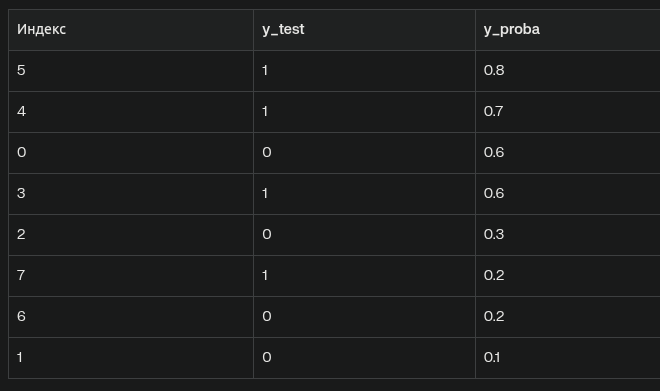 


Шаг 2. Считаем общее количество положительных (P) и отрицательных (N):
P = число единиц = 4 (индексы 3,4,5,7)

N = число нулей = 4 (индексы 0,1,2,6)

Шаг 3. Уникальные пороги — значения вероятностей по убыванию (добавим 1.0 для точки начала):
Пороги: [1.0 (точка начала), 0.8, 0.7, 0.6, 0.3, 0.2, 0.1, 0.0 (точка в конце)]

Правила классификации при пороге t:  
    Если score ≥ t — классифицируем как положительный (1), иначе отрицательный (0).  
Вычисляем TP, FP, FN, TN, а затем TPR и FPR для каждого порога:  

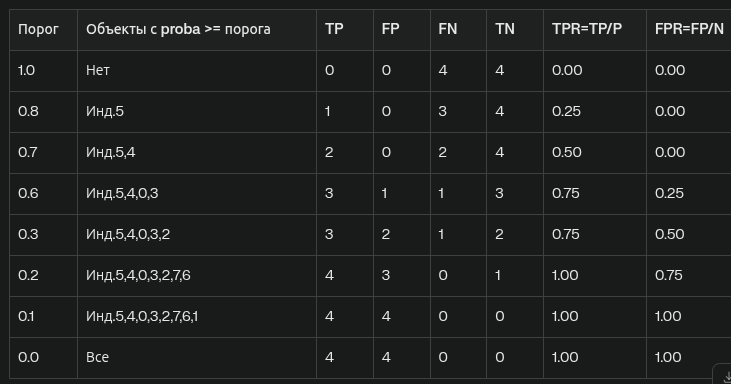
 
Добавляем точку начала (порог > максимума, никакие объекты не положительные, значит TPR=0, FPR=0):  

При пороге 1.0 никто не классифицирован положительным → TP=0, FP=0.  

При пороге 0.8 положительный класс присвоен индексу 5 (y=1) → TP=1, FP=0.  

При пороге 0.6 положительные — индексы 5,4,0,3, где индекс 0 — класс 0 → FP увеличился на 1.  

И так далее.  

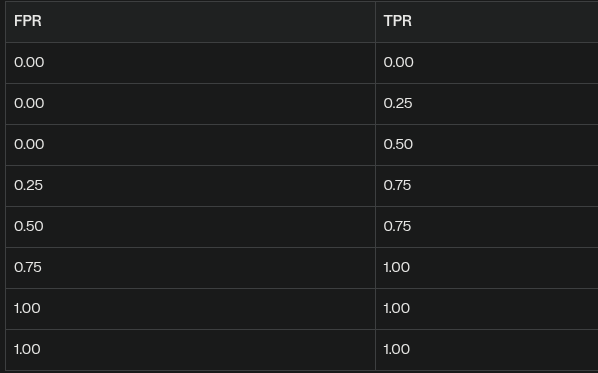 

Построение графика:  

По оси X откладываем False Positive Rate (FPR).  

По оси Y откладываем True Positive Rate (TPR).  

Соединяем точки в порядке возрастания FPR:  

(0,0) → (0,0.33) → (0,0.67) → (0,1) → (0.33,1) → (0.67,1) → (1,1)  


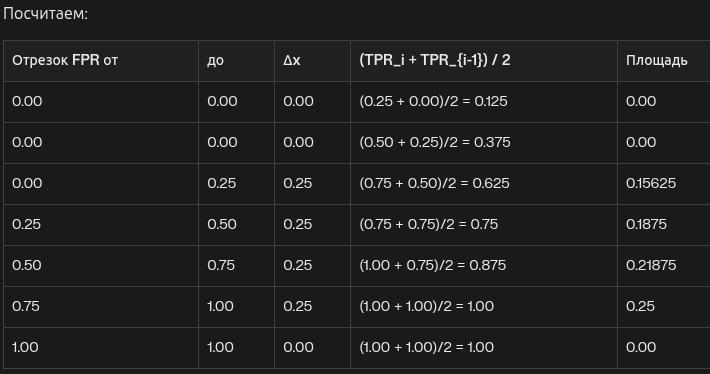  

Сумма площадей:  ` 0+0+0.15625+0.1875+0.21875+0.25+0=0.8125 `

ROC AUC torch: 0.8125


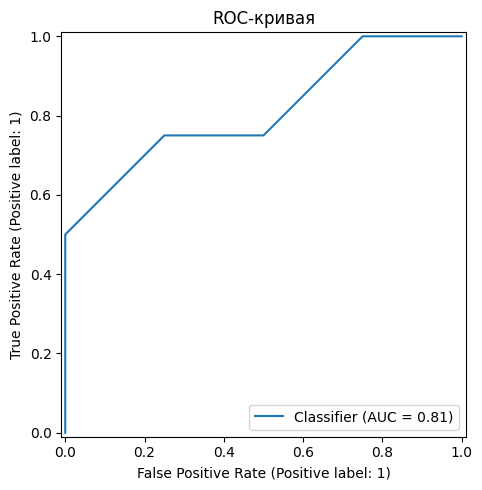

In [26]:
# ПРИМЕР

y_test = [0, 0, 0, 1, 1, 1, 0, 1]  
y_proba = [0.6, 0.1, 0.3, 0.6, 0.7, 0.8, 0.2, 0.2] 

targets = torch.tensor(y_test)
preds_prob = torch.tensor(y_proba)

# ROC AUC (нужны вероятности, для примера используем float тензор)
auroc = AUROC(task="binary")
roc_auc = auroc(preds_prob, targets)
print(f"ROC AUC torch: {roc_auc.item():.4f}")

# 5. Визуализация

plt.figure(figsize=(18, 5))


# 5.3 ROC-кривая
roc_disp = RocCurveDisplay.from_predictions(y_test, y_proba, ax=plt.gca())
plt.title('ROC-кривая')

plt.tight_layout()
plt.show()

## 3) Метрики компьютерного зрения  
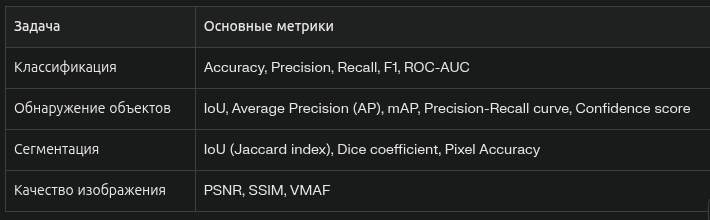 

### 1. Object Detection

#### 1) IoU

##### Custom 
Без учёта классов и батчей

In [27]:
# Для пары боксов
def iou_custom(boxA, boxB):
    # box = [x_min, y_min, x_max, y_max]
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    
    interArea = max(0, xB - xA) * max(0, yB - yA)
    
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

# Пример
pred_box = torch.tensor([50, 50, 150, 150], dtype=torch.float)
true_box = torch.tensor([60, 60, 140, 140], dtype=torch.float)

print("IoU:", iou_custom(pred_box, true_box).item())


IoU: 0.6399999856948853


In [28]:
# Для всех боксов
import torch

def iou_all_boxes(boxes1, boxes2):
    # boxes1 и boxes2 - тензоры размера (N,4) и (M,4)
    # форматы боксов: [x_min, y_min, x_max, y_max]
    
    N = boxes1.shape[0]
    M = boxes2.shape[0]
    
    # Расширяем размерности для векторных операций:
    boxes1 = boxes1.unsqueeze(1).expand(N, M, 4)  # (N, M, 4)
    boxes2 = boxes2.unsqueeze(0).expand(N, M, 4)  # (N, M, 4)
    
    # Вычисляем координаты пересечения
    xA = torch.max(boxes1[:, :, 0], boxes2[:, :, 0])
    yA = torch.max(boxes1[:, :, 1], boxes2[:, :, 1])
    xB = torch.min(boxes1[:, :, 2], boxes2[:, :, 2])
    yB = torch.min(boxes1[:, :, 3], boxes2[:, :, 3])
    
    # Вычисляем площадь пересечения
    interWidth = (xB - xA).clamp(min=0)
    interHeight = (yB - yA).clamp(min=0)
    interArea = interWidth * interHeight
    
    # Площади боксов
    boxAArea = (boxes1[:, :, 2] - boxes1[:, :, 0]) * (boxes1[:, :, 3] - boxes1[:, :, 1])
    boxBArea = (boxes2[:, :, 2] - boxes2[:, :, 0]) * (boxes2[:, :, 3] - boxes2[:, :, 1])
    
    # Вычисляем union площадь
    unionArea = boxAArea + boxBArea - interArea
    
    iou = interArea / unionArea
    return iou  # (N, M) матрица IoU для всех пар боксов



In [29]:
pred_boxes = torch.tensor([[50, 50, 150, 150],
                           [30, 30, 70, 70]], dtype=torch.float)

true_boxes = torch.tensor([[60, 60, 140, 140],
                           [35, 35, 65, 65]], dtype=torch.float)

ious = iou_all_boxes(pred_boxes, true_boxes)
print(ious)
# Выведет матрицу  такого вида:
# tensor([[0.64, 0.0 ],
#         [0.0 , 0.56]])


tensor([[0.6400, 0.0211],
        [0.0127, 0.5625]])


##### torchvision

In [30]:
from torchvision.ops import box_iou

ious = box_iou(pred_boxes, true_boxes)
print("IoU torchvision:\n", ious)

# Для каждого предсказания выбираем максимум по истинным
max_ious_per_pred = ious.max(dim=1).values  # tensor([0.64, 0.5625])

# Усредняем
mean_iou = max_ious_per_pred.mean()
print(f"Среднее IoU per prediction: {mean_iou.item():.4f}")


IoU torchvision:
 tensor([[0.6400, 0.0211],
        [0.0127, 0.5625]])
Среднее IoU per prediction: 0.6012


##### torchmetrics 
Предпочтительнее - инкапсулирует вычисление IoU, фильтрацию по классам, обработку батчей и аккумулирование, что избавляет от написания дополнительного кода и снижает вероятность ошибок.

In [31]:
import torch
from torchmetrics.detection import IntersectionOverUnion

preds = [
    {
        "boxes": torch.tensor([[50, 50, 150, 150], [30, 30, 70, 70]], dtype=torch.float),
        "labels": torch.tensor([1, 0]),
        "scores": torch.tensor([0.9, 0.8]),
    }
]

target = [
    {
        "boxes": torch.tensor([[60, 60, 140, 140], [35, 35, 65, 65]], dtype=torch.float),
        "labels": torch.tensor([1, 0]),
    }
]

iou_metric = IntersectionOverUnion()
iou = iou_metric(preds, target)
print("IoU torchmetrics:\n", iou)  # Выведет словарь с ключом "iou" и значением — вычисленным IoU
print(f"Среднее IoU: {iou['iou'].item():.4f}")

IoU torchmetrics:
 {'iou': tensor(0.6012)}
Среднее IoU: 0.6012


#### 2) recal

##### custom  
Без учёта классов и батчей

In [32]:
import torch

def iou(boxA, boxB):
    # box = [x_min, y_min, x_max, y_max]
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    
    interWidth = max(0, xB - xA)
    interHeight = max(0, yB - yA)
    interArea = interWidth * interHeight
    
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    
    unionArea = boxAArea + boxBArea - interArea
    
    if unionArea == 0:
        return 0.0
    else:
        return interArea / unionArea

def recall_metric(pred_boxes, true_boxes, iou_threshold=0.5):
    """
    pred_boxes, true_boxes - списки боксов [x_min, y_min, x_max, y_max]
    iou_threshold - порог IoU для определения совпадения
    Возвращает Recall: долю истинных объектов, найденных предсказаниями.
    """
    matched_true = set()  # для хранения индексов уже найденных истинных боксов

    for pred_box in pred_boxes:
        for idx, true_box in enumerate(true_boxes):
            if idx in matched_true:
                continue  # этот истинный бокс уже найден
            if iou(pred_box, true_box) >= iou_threshold:
                matched_true.add(idx)
                break  # предсказание сопоставлено, переходим к следующему

    recall = len(matched_true) / len(true_boxes) if len(true_boxes) > 0 else 0.0
    return recall

# Пример использования:
predicted_boxes = [
    [50, 50, 150, 150],
    [30, 30, 70, 70],
    # [200, 200, 300, 300]  # Не уменьшает recal
]

true_boxes = [
    [60, 60, 140, 140],
    [35, 35, 65, 65],
    [200, 200, 300, 300]  # Третий истинный бокс пропущен моделью
]

recall_value = recall_metric(predicted_boxes, true_boxes, iou_threshold=0.5)
print(f"Recall: {recall_value:.4f}")  # Ожидается значение 2/3 = 0.6667



Recall: 0.6667


#### 3) Precision

##### Custom 
Без учёта классов и батчей

In [33]:
def iou(boxA, boxB):
    # box = [x_min, y_min, x_max, y_max]
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    
    interWidth = max(0, xB - xA)
    interHeight = max(0, yB - yA)
    interArea = interWidth * interHeight
    
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    
    unionArea = boxAArea + boxBArea - interArea
    
    if unionArea == 0:
        return 0.0
    else:
        return interArea / unionArea

def precision_metric(pred_boxes, true_boxes, iou_threshold=0.5):
    """
    pred_boxes, true_boxes - списки боксов [x_min, y_min, x_max, y_max]
    iou_threshold - порог IoU для определения совпадения
    Возвращает Precision: долю верных предсказанных боксов среди всех предсказаний.
    """
    matched_true = set()  # для отслеживания уже найденных истинных боксов
    true_matched_for_pred = set()  # для отслеживания, какие предсказания уже сопряжены
    
    true_boxes_idx_matched = set()
    
    # Для каждого предсказания пытаемся найти совпадение в истинных боксах
    for i, pred_box in enumerate(pred_boxes):
        matched = False
        for j, true_box in enumerate(true_boxes):
            if j in true_boxes_idx_matched:
                continue  # этот истинный бокс уже сопоставлен
    
            if iou(pred_box, true_box) >= iou_threshold:
                matched_true.add(i)        # i-й предсказанный бокс — True Positive
                true_boxes_idx_matched.add(j)  # j-й истинный бокс связан
                matched = True
                break
    
    TP = len(matched_true)              # число истинно положительных предсказаний
    FP = len(pred_boxes) - TP           # лишние предсказания
    
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    return precision

# Пример использования:
predicted_boxes = [
    [50, 50, 150, 150],
    [30, 30, 70, 70],
    [200, 200, 300, 300]  # лишний бокс
]

true_boxes = [
    [60, 60, 140, 140],
    [35, 35, 65, 65],
    # [200, 200, 300, 300] # Не влияет на Precision
]

precision_value = precision_metric(predicted_boxes, true_boxes, iou_threshold=0.5)
print(f"Precision: {precision_value:.4f}")  # Ожидается < 1.0 из-за лишнего бокса


Precision: 0.6667


#### 4) f1_metrics

##### Custom

In [34]:
import torch

def iou(boxA, boxB):
    # boxA, boxB: тензоры [4] в формате [x_min, y_min, x_max, y_max]
    xA = torch.max(boxA[0], boxB[0])
    yA = torch.max(boxA[1], boxB[1])
    xB = torch.min(boxA[2], boxB[2])
    yB = torch.min(boxA[3], boxB[3])

    interW = (xB - xA).clamp(min=0)
    interH = (yB - yA).clamp(min=0)
    interArea = interW * interH

    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    unionArea = boxAArea + boxBArea - interArea

    return interArea / unionArea if unionArea > 0 else 0

def f1_detection_metric_batch(preds, targets, iou_threshold=0.5, num_classes=None):
    """
    preds и targets - списки словарей по батчу, где каждый элемент:
      {
        "boxes": Tensor [N,4],
        "labels": Tensor [N]
      }
    iou_threshold - порог IoU для определения True Positive
    num_classes - количество классов (если None, вывод по всем встреченным классам)
    
    Возвращает: словарь с F1 для каждого класса и среднее F1 по всем классам
    """
    # Подсчёт TP, FP, FN на класс
    tp_per_class = {}
    fp_per_class = {}
    fn_per_class = {}

    # Собираем все классы если num_classes не задан
    all_classes = set()
    for batch_entry in preds + targets:
        all_classes.update(batch_entry["labels"].tolist())
    if num_classes is not None:
        all_classes = set(range(num_classes))
    
    for cls in all_classes:
        tp_per_class[cls] = 0
        fp_per_class[cls] = 0
        fn_per_class[cls] = 0

    for pred, target in zip(preds, targets):
        pred_boxes = pred["boxes"]
        pred_labels = pred["labels"]
        target_boxes = target["boxes"]
        target_labels = target["labels"]

        for cls in all_classes:
            # Отбираем боксы нужного класса
            pred_mask = (pred_labels == cls)
            target_mask = (target_labels == cls)

            pred_boxes_cls = pred_boxes[pred_mask]
            target_boxes_cls = target_boxes[target_mask]

            matched_gt = set()
            matched_pred = set()

            # Сопоставляем боксы с IoU >= threshold
            for i_pred, pb in enumerate(pred_boxes_cls):
                ious = torch.tensor([iou(pb, tb) for tb in target_boxes_cls])
                max_iou, max_idx = torch.max(ious, dim=0) if len(ious) > 0 else (torch.tensor(0), -1)

                if max_iou >= iou_threshold and max_idx.item() not in matched_gt:
                    tp_per_class[cls] += 1
                    matched_gt.add(max_idx.item())
                    matched_pred.add(i_pred)
                else:
                    # Неподходящее предсказание
                    pass

            fp_per_class[cls] += len(pred_boxes_cls) - len(matched_pred)
            fn_per_class[cls] += len(target_boxes_cls) - len(matched_gt)

    f1_per_class = {}
    for cls in all_classes:
        tp = tp_per_class[cls]
        fp = fp_per_class[cls]
        fn = fn_per_class[cls]

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

        f1_per_class[cls] = f1

    mean_f1 = sum(f1_per_class.values()) / len(f1_per_class) if f1_per_class else 0.0

    return {"f1_per_class": f1_per_class, "mean_f1": mean_f1}

# Пример использования:
# preds и targets - листы словарей с "boxes" и "labels"
preds = [
    {
        "boxes": torch.tensor([[50, 50, 150, 150], [200, 200, 300, 300]], dtype=torch.float),
        "labels": torch.tensor([0, 1])
    },
    {
        "boxes": torch.tensor([[30, 30, 70, 70]], dtype=torch.float),
        "labels": torch.tensor([0])  # здесь ошиблись
    }
]

targets = [
    {
        "boxes": torch.tensor([[60, 60, 140, 140], [190, 190, 310, 310]], dtype=torch.float),
        "labels": torch.tensor([0, 1])
    },
    {
        "boxes": torch.tensor([[35, 35, 65, 65]], dtype=torch.float),
        "labels": torch.tensor([1])
    }
]

result = f1_detection_metric_batch(preds, targets, iou_threshold=0.5, num_classes=2)
print("F1 per class:", result["f1_per_class"])
print("Mean F1:", result["mean_f1"])


F1 per class: {0: 0.6666666666666666, 1: 0.6666666666666666}
Mean F1: 0.6666666666666666


#### 5) Общая

In [35]:
import torch
from torchmetrics.detection import MeanAveragePrecision

# Инициализация метрики
metric = MeanAveragePrecision(iou_type="bbox")  # для bounding boxes

# Формат данных: списки словарей (по батчу), каждый словарь с ключами boxes, scores, labels
# Предсказания
preds = [
    {
        "boxes": torch.tensor([[50, 50, 150, 150], [200, 200, 300, 300]], dtype=torch.float),
        "scores": torch.tensor([0.9, 0.8]),
        "labels": torch.tensor([0, 1])
    },
    {
        "boxes": torch.tensor([[30, 30, 70, 70]], dtype=torch.float),
        "scores": torch.tensor([0.85]),
        "labels": torch.tensor([0])
    }
]

# Истинные метки
targets = [
    {
        "boxes": torch.tensor([[60, 60, 140, 140], [190, 190, 310, 310]], dtype=torch.float),
        "labels": torch.tensor([0, 1])
    },
    {
        "boxes": torch.tensor([[35, 35, 65, 65]], dtype=torch.float),
        "labels": torch.tensor([0])
    }
]

# targets = [
#     {
#         "boxes": torch.tensor([[50, 50, 150, 150], [200, 200, 300, 300]], dtype=torch.float),
#         "labels": torch.tensor([0, 1])
#     },
#     {
#         "boxes": torch.tensor([[30, 30, 70, 70]], dtype=torch.float),
#         "labels": torch.tensor([0])
#     }
# ]



# Обновляем метрику по батчу
metric.update(preds, targets)

# Вычисляем итоговые метрики
result = metric.compute()

print(result)


{'map': tensor(0.3252), 'map_50': tensor(1.), 'map_75': tensor(0.), 'map_small': tensor(0.2000), 'map_medium': tensor(0.3000), 'map_large': tensor(0.4000), 'mar_1': tensor(0.3250), 'mar_10': tensor(0.3250), 'mar_100': tensor(0.3250), 'mar_small': tensor(0.2000), 'mar_medium': tensor(0.3000), 'mar_large': tensor(0.4000), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([0, 1], dtype=torch.int32)}


In [36]:
precision_approx = result.get("map")      # mean average precision
recall_approx = result.get("mar_100")    # mean average recall at top 100 detections

if precision_approx is not None and recall_approx is not None and (precision_approx + recall_approx) > 0:
    f1_approx = 2 * precision_approx * recall_approx / (precision_approx + recall_approx)
else:
    f1_approx = None

print(f"F1 score (approx): {f1_approx}")



F1 score (approx): 0.32512369751930237


### 2. Image Segmentation

#### 1) IoU

##### Custom 

In [37]:
# с одним классом (бинарная) без батчей

# С numpy
import numpy as np

# Пример масок (numpy boolean arrays)
mask_true = np.array([[1,1,0],[0,1,0],[0,0,1]], dtype=bool)
mask_pred = np.array([[1,0,0],[0,1,1],[0,0,1]], dtype=bool)

def iou_segmentation(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return intersection / union


print("IoU (segmentation):", iou_segmentation(mask_true, mask_pred))


# с Toch
import torch

def iou_segmentation_torch(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
    """
    Вычисляет IoU для булевых масок (segmentation masks) на PyTorch.
    
    Параметры:
    - y_true: булевый тензор с истинными масками
    - y_pred: булевый тензор с предсказанными масками
    
    Возвращает:
    - scalar tensor с IoU (float)
    """
    intersection = torch.logical_and(y_true, y_pred).sum(dtype=torch.float32)
    union = torch.logical_or(y_true, y_pred).sum(dtype=torch.float32)
    iou = intersection / union if union > 0 else torch.tensor(1.0)  # если нет ни одного пикселя — IoU=1
    return iou

# Пример использования
mask_true = torch.tensor([[1, 1, 0],
                          [0, 1, 0],
                          [0, 0, 1]], dtype=torch.bool)

mask_pred = torch.tensor([[1, 0, 0],
                          [0, 1, 1],
                          [0, 0, 1]], dtype=torch.bool)

iou_value = iou_segmentation_torch(mask_true, mask_pred)
print("IoU (segmentation, torch):", iou_value.item())



IoU (segmentation): 0.6
IoU (segmentation, torch): 0.6000000238418579


In [38]:
# Многоклассовая
# С Numpy
import numpy as np

def iou_multiclass_batch(y_true, y_pred, num_classes, ignore_index=None):
    """
    Вычисляет средний IoU для многоклассовой сегментации по батчу.

    Параметры:
    - y_true: numpy array формы (batch, height, width), истинные метки (целые числа - классы)
    - y_pred: numpy array формы (batch, height, width), предсказанные метки
    - num_classes: int, количество классов
    - ignore_index: int или None, метка класса, которую игнорировать (например, фон)

    Возвращает:
    - mean_iou: средний IoU по всем классам (без учёта ignore_index)
    - per_class_iou: словарь с IoU по каждому классу
    """

    batch_size = y_true.shape[0]
    per_class_ious = {cls: [] for cls in range(num_classes) if cls != ignore_index}

    for b in range(batch_size):
        true_mask = y_true[b]
        pred_mask = y_pred[b]

        for cls in range(num_classes):
            if cls == ignore_index:
                continue
            
            true_cls = (true_mask == cls)
            pred_cls = (pred_mask == cls)

            intersection = np.logical_and(true_cls, pred_cls).sum()
            union = np.logical_or(true_cls, pred_cls).sum()

            if union == 0:
                # Если класс отсутствует и в предсказании и в истине, можно считать IoU = np.nan или 1.0 по контексту
                iou = np.nan
            else:
                iou = intersection / union
            
            per_class_ious[cls].append(iou)

    per_class_iou_avg = {}
    for cls, ious in per_class_ious.items():
        ious_arr = np.array(ious)
        # Усредняем по батчу, игнорируя nan
        valid_ious = ious_arr[~np.isnan(ious_arr)]
        if len(valid_ious) == 0:
            avg_iou = np.nan
        else:
            avg_iou = valid_ious.mean()
        per_class_iou_avg[cls] = avg_iou

    # Среднее IoU по классам, игнорируя nan
    class_iou_values = np.array([v for v in per_class_iou_avg.values() if not np.isnan(v)])
    mean_iou = class_iou_values.mean() if len(class_iou_values) > 0 else np.nan

    return mean_iou, per_class_iou_avg


# Пример использования:

y_true = np.array([
    [[1,1,0],[0,1,0],[0,0,2]],
    [[0,0,1],[1,2,2],[0,0,0]]
])

y_pred = np.array([
    [[1,0,0],[0,1,1],[0,0,2]],
    [[0,0,1],[1,1,2],[2,0,0]]
])

num_classes = 3  # классы: 0,1,2
mean_iou, per_class_iou = iou_multiclass_batch(y_true, y_pred, num_classes=num_classes, ignore_index=None)

print("Mean IoU:", mean_iou)
print("IoU по классам:", per_class_iou)



# С Torch
def iou_multiclass_batch_torch(y_true: torch.Tensor, y_pred: torch.Tensor, num_classes: int, ignore_index=None):
    """
    Вычисляет среднее IoU по классам и по батчу для многоклассовой сегментации.
    
    Параметры:
    - y_true: тензор с истинными метками классов, размерность (N, H, W)
    - y_pred: тензор с предсказанными метками классов, размерность (N, H, W)
    - num_classes: количество классов
    - ignore_index: класс для игнорирования (например, фон), можно None
    
    Возвращает:
    - mean_iou: среднее IoU по классам и батчу (float)
    - per_class_iou: dict с IoU по классам
    """
    per_class_ious = {}
    for cls in range(num_classes):
        if cls == ignore_index:
            continue
        
        true_cls = (y_true == cls)
        pred_cls = (y_pred == cls)
        
        intersection = torch.logical_and(true_cls, pred_cls).sum(dim=(1, 2)).float()  # по каждому изображению в батче
        union = torch.logical_or(true_cls, pred_cls).sum(dim=(1, 2)).float()

        # Избегаем деления на 0
        ious = torch.where(union > 0, intersection / union, torch.tensor(float('nan'), device=union.device))
        
        # Усреднение по батчу, игнорируем nan
        valid_ious = ious[~torch.isnan(ious)]
        if len(valid_ious) > 0:
            avg_iou = valid_ious.mean().item()
        else:
            avg_iou = float('nan')

        per_class_ious[cls] = avg_iou

    # Среднее по классам (игнорируем nan)
    valid_class_ious = [v for v in per_class_ious.values() if not (v != v)]  # nan проверка
    mean_iou = sum(valid_class_ious) / len(valid_class_ious) if valid_class_ious else float('nan')
    
    return mean_iou, per_class_ious


# Пример для батча из 2 изображений, 3 классов
y_true = torch.tensor([
    [[1,1,0],[0,1,0],[0,0,2]],
    [[0,0,1],[1,2,2],[0,0,0]]
])

y_pred = torch.tensor([
    [[1,0,0],[0,1,1],[0,0,2]],
    [[0,0,1],[1,1,2],[2,0,0]]
])

# y_pred = torch.tensor([
#     [[1,1,0],[0,1,0],[0,0,2]],
#     [[0,0,1],[1,2,2],[2,0,0]]
# ])
    

mean_iou, per_class_iou = iou_multiclass_batch_torch(y_true, y_pred, num_classes=3, ignore_index=None)
print("Mean IoU:", mean_iou)
print("IoU per class:", per_class_iou)


Mean IoU: 0.6611111111111111
IoU по классам: {0: np.float64(0.7333333333333334), 1: np.float64(0.5833333333333333), 2: np.float64(0.6666666666666666)}
Mean IoU: 0.6611111362775167
IoU per class: {0: 0.7333333492279053, 1: 0.5833333730697632, 2: 0.6666666865348816}


##### torchmetrics


In [39]:
import torch
from torchmetrics.classification import MulticlassJaccardIndex

# Инициализация метрики для 3 классов
num_classes = 3
iou_metric = MulticlassJaccardIndex(num_classes=num_classes, ignore_index=None)

# Пример батча
y_true = torch.tensor([
    [[1,1,0],
     [0,1,0],
     [0,0,2]],

    [[0,0,1],
     [1,2,2],
     [0,0,0]]
])

y_pred = torch.tensor([
    [[1,0,0],
     [0,1,1],
     [0,0,2]],

    [[0,0,1],
     [1,1,2],
     [2,0,0]]
])


per_class_iou = iou_metric(y_pred, y_true)  # тензор со значениями по классам
print("IoU (torchmetrics):", per_class_iou)


IoU (torchmetrics): tensor(0.5996)


#### 2) Dice

##### Custom

In [40]:
## Бинарная
# Numpy
mask_true = np.array([[1,1,0],[0,1,0],[0,0,1]], dtype=bool)
mask_pred = np.array([[1,0,0],[0,1,1],[0,0,1]], dtype=bool)
def dice_coefficient(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    return 2 * intersection / (y_true.sum() + y_pred.sum())

print("Dice Coefficient Numpy (binary):", dice_coefficient(mask_true, mask_pred))


# torch  Бинарная с батчами
import torch

def dice_coefficient_binary(y_true: torch.Tensor, y_pred: torch.Tensor, smooth=1e-6) -> torch.Tensor:
    """
    Вычисляет Dice Coefficient для бинарной сегментации с батчами.
    
    Аргументы:
        y_true: тензор истинных масок, dtype=bool или 0/1, форма (N, H, W) или (N, 1, H, W)
        y_pred: тензор предсказанных масок, dtype=bool или 0/1, такая же форма, как y_true
        smooth: сглаживающий коэффициент для избежания деления на 0
    
    Возвращает:
        Scalar tensor с усреднённым Dice Coefficient по батчу
    """
    assert y_true.shape == y_pred.shape, "y_true and y_pred must have the same shape"
    
    y_true = y_true.bool()
    y_pred = y_pred.bool()
    
    intersection = (y_true & y_pred).sum(dim=[1, 2, 3] if y_true.dim() == 4 else [1, 2]).float()
    cardinality = y_true.sum(dim=[1, 2, 3] if y_true.dim() == 4 else [1, 2]).float() + \
                  y_pred.sum(dim=[1, 2, 3] if y_pred.dim() == 4 else [1, 2]).float()
    
    dice = (2. * intersection + smooth) / (cardinality + smooth)
    return dice.mean()

# Пример бинарных масок батча (N=2, H=3, W=3)
y_true = torch.tensor([
    [[1,1,0],[0,1,0],[0,0,1]],
    [[0,0,1],[1,0,0],[0,0,0]]
], dtype=torch.uint8)  # или torch.bool

y_pred = torch.tensor([
    [[1,0,0],[0,1,1],[0,0,1]],
    [[0,0,1],[1,1,0],[0,0,0]]
], dtype=torch.uint8)

dice = dice_coefficient_binary(y_true, y_pred)
print(f"Dice Coefficient torch (binary): {dice.item():.4f}")


Dice Coefficient Numpy (binary): 0.75
Dice Coefficient torch (binary): 0.7750


In [41]:
# Многклассовая  с батчами
import torch

def dice_coefficient_multiclass(y_true: torch.Tensor, y_pred: torch.Tensor, num_classes: int, ignore_index: int = None, smooth=1e-6):
    """
    Вычисляет Dice Coefficient для многоклассовой сегментации с батчами.
    
    Аргументы:
        y_true: тензор истинных меток класса, shape (N, H, W), dtype long
        y_pred: тензор предсказанных меток класса, shape (N, H, W), dtype long
        num_classes: количество классов
        ignore_index: класс, который игнорируется при подсчёте (например, фон)
        smooth: сглаживающий коэффициент
    
    Возвращает:
        Тензор scalar с усреднённым Dice по классам и батчу
    """
    assert y_true.shape == y_pred.shape, "Shape of y_true and y_pred must match"
    
    dices = []
    
    for cls in range(num_classes):
        if cls == ignore_index:
            continue
        
        true_cls = (y_true == cls)
        pred_cls = (y_pred == cls)
        
        intersection = (true_cls & pred_cls).sum(dim=[1, 2]).float()
        cardinality = true_cls.sum(dim=[1, 2]).float() + pred_cls.sum(dim=[1, 2]).float()
        
        dice_per_sample = (2 * intersection + smooth) / (cardinality + smooth)
        dices.append(dice_per_sample.mean())  # усреднение по батчу для класса
    
    if len(dices) == 0:
        return torch.tensor(0.0)
    
    return torch.stack(dices).mean()  # усреднение по классам

y_true2 = torch.tensor([
    [[1,1,0],
     [0,1,0],
     [0,0,2]],
    [[0,0,1],
     [1,2,2],
     [0,0,0]]
], dtype=torch.long)

y_pred2 = torch.tensor([
    [[1,0,0],
     [0,1,1],
     [0,0,2]],
    [[0,0,1],
     [1,1,2],
     [2,0,0]]
], dtype=torch.long)

dice_mc_custom = dice_coefficient_multiclass(y_true2, y_pred2, num_classes=3, ignore_index=None)
print(f"Dice Coefficient (multiclass): {dice_mc_custom.item():.4f}")


Dice Coefficient (multiclass): 0.7759


##### Готовая torch

In [42]:
from torchmetrics.segmentation import DiceScore

# Для бинарной сегментации (num_classes=1)
dice = DiceScore(num_classes=1)

# Для многоклассовой сегментации (num_classes > 1)
dice_mc = DiceScore(num_classes=3, average='macro', input_format='index')

dice = dice(y_true, y_pred)
print(f"Dice Coefficient torchmetrics (binary): {dice.item():.4f}")

score = dice_mc(y_pred2, y_true2)  
print(f"Dice score (torchmetrics): {score.item():.4f}")

Dice Coefficient torchmetrics (binary): 0.7750
Dice score (torchmetrics): 0.7759


/home/maksim/develops/python/env1/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: DiceScore metric currently defaults to `average=micro`, but will change to`average=macro` in the v1.9 release. If you've explicitly set this parameter, you can ignore this warning.
  warnings.warn(*args, **kwargs)


#### 3) Accuracy

##### Custom

In [43]:
import torch

def multiclass_segmentation_accuracy(preds: torch.Tensor, target: torch.Tensor, ignore_index: int = None) -> torch.Tensor:
    """
    Вычисляет accuracy для многоклассовой сегментации с учётом батча.
    
    Аргументы:
    - preds: тензор предсказаний с метками классов (N, H, W), dtype long
    - target: тензор истинных меток классов (N, H, W), dtype long
    - ignore_index: int или None — класс, который игнорируется при подсчёте
    
    Возвращает:
    - accuracy: scalar tensor с accuracy (float)
    """
    assert preds.shape == target.shape, "Shape of preds and target must match"
    assert preds.dtype == torch.long and target.dtype == torch.long, "Preds and target must be of type long"

    if ignore_index is not None:
        # Формируем маску для пикселей, которые нужно учитывать (не равны ignore_index)
        valid_mask = (target != ignore_index)
        correct = (preds == target) & valid_mask
        total = valid_mask.sum()
    else:
        correct = (preds == target)
        total = torch.numel(target)  # общее число пикселей

    correct_count = correct.sum().float()
    accuracy = correct_count / total if total > 0 else torch.tensor(0.0, device=preds.device)
    return accuracy

# Пример использования
if __name__ == "__main__":
    # Батч из 2 изображений 3x3, 3 класса (0,1,2)
    y_true = torch.tensor([
        [[1,1,0],
         [0,1,0],
         [0,0,2]],
        [[0,0,1],
         [1,2,2],
         [0,0,0]]
    ]).long()

    y_pred = torch.tensor([
        [[1,0,0],
         [0,1,1],
         [0,0,2]],
        [[0,0,1],
         [1,1,2],
         [2,0,0]]
    ]).long()

    acc = multiclass_segmentation_accuracy(y_pred, y_true)
    print(f"Accuracy: {acc.item():.4f}")


Accuracy: 0.7778


##### torchmetrics

In [44]:
## Бинарная
import torch
from torchmetrics.classification import BinaryAccuracy

# Инициализация метрики
metric = BinaryAccuracy(threshold=0.5, ignore_index=None)

# Предсказания и истинные метки (batch_size=2, H=3, W=3)
y_true = torch.tensor([
    [[1, 1, 0],
     [0, 1, 0],
     [0, 0, 1]],
    [[0, 0, 1],
     [1, 1, 0],
     [0, 0, 0]]
], dtype=torch.int)

# Предсказания: вероятности (тип float)
y_pred = torch.tensor([
    [[0.9, 0.8, 0.3],
     [0.4, 0.7, 0.6],
     [0.1, 0.05, 0.95]],
    [[0.2, 0.1, 0.9],
     [0.8, 0.7, 0.4],
     [0.2, 0.3, 0.1]]
], dtype=torch.float)

acc = metric(y_pred, y_true)
print(f"Binary Accuracy: {acc.item():.4f}")


Binary Accuracy: 0.9444


In [45]:
## Многоклассовая
import torch
from torchmetrics.classification import MulticlassAccuracy

num_classes = 3
metric = MulticlassAccuracy(num_classes=num_classes, ignore_index=None)

# Истинные метки (batch=2, H=3, W=3)
y_true = torch.tensor([
    [[1,1,0],
     [0,1,0],
     [0,0,2]],
    [[0,0,1],
     [1,2,2],
     [0,0,0]]
], dtype=torch.int)

# Предсказания - метки классов
y_pred = torch.tensor([
    [[1,0,0],
     [0,1,1],
     [0,0,2]],
    [[0,0,1],
     [1,1,2],
     [2,0,0]]
], dtype=torch.int)

acc = metric(y_pred, y_true)
print(f"Multiclass Accuracy: {acc.item():.4f}")


Multiclass Accuracy: 0.7556


### 3. Image Quality Assessment

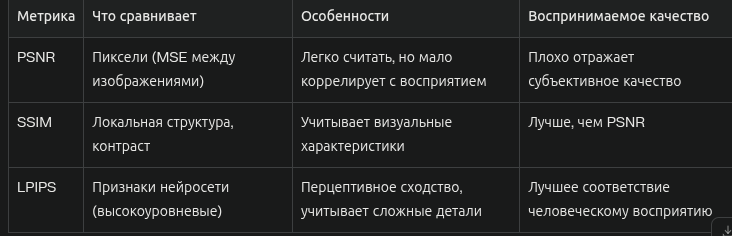 

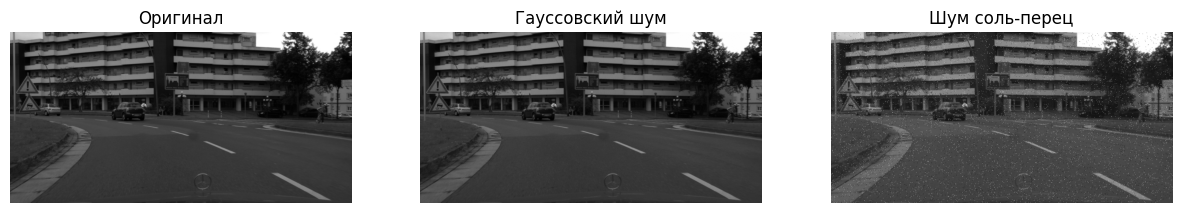

In [46]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img1 = cv2.imread('../../data/image/1.png', cv2.IMREAD_GRAYSCALE)

def add_gaussian_noise(image, mean=0, sigma=25):
    """Добавляет гауссовский шум."""
    gauss = np.random.normal(mean, sigma, image.shape).astype('float32')
    noisy = image.astype('float32') + gauss
    noisy = np.clip(noisy, 0, 255).astype('uint8')
    return noisy

def add_salt_and_pepper_noise(image, salt_prob=0.01, pepper_prob=0.01):
    """Добавляет шум типа соль-перец."""
    noisy = np.copy(image)
    total_pixels = image.size

    # Соль (белые пиксели)
    num_salt = np.ceil(salt_prob * total_pixels).astype(int)
    coords_salt = [np.random.randint(0, i, num_salt) for i in image.shape]
    noisy[coords_salt[0], coords_salt[1]] = 255

    # Перец (черные пиксели)
    num_pepper = np.ceil(pepper_prob * total_pixels).astype(int)
    coords_pepper = [np.random.randint(0, i, num_pepper) for i in image.shape]
    noisy[coords_pepper[0], coords_pepper[1]] = 0

    return noisy

# Добавим шумы
img_gauss = add_gaussian_noise(img1, mean=0, sigma=1)
img_sp = add_salt_and_pepper_noise(img1, salt_prob=0.01, pepper_prob=0.01)

# Визуализация для сравнения
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('Оригинал')
plt.imshow(img1, cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.title('Гауссовский шум')
plt.imshow(img_gauss, cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.title('Шум соль-перец')
plt.imshow(img_sp, cmap='gray')
plt.axis('off')

plt.show()


In [47]:
import cv2
from skimage.metrics import structural_similarity as ssim
import numpy as np


# PSNR
psnr_value = cv2.PSNR(img_gauss, img1)
print("PSNR:", psnr_value)

# SSIM
ssim_value, ssim_map = ssim(img_gauss, img1, full=True)
print("SSIM:", ssim_value)


PSNR: 46.89003342358558
SSIM: 0.9889534926169754


In [48]:
# PSNR
psnr_value = cv2.PSNR(img_sp, img1)
print("PSNR:", psnr_value)

# SSIM
ssim_value, ssim_map = ssim(img_sp, img1, full=True)
print("SSIM:", ssim_value)


PSNR: 22.02307583039476
SSIM: 0.5796681176095276


In [49]:
import lpips
import torch
from PIL import Image
import torchvision.transforms as transforms
import numpy as np

# Создаем объект метрики LPIPS
loss_fn = lpips.LPIPS(net='alex')  # Можно выбрать 'alex', 'vgg' и др.

# Функция загрузки изображения в RGB и преобразования для LPIPS
def load_image(path):
    img = Image.open(path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    img_t = transform(img).unsqueeze(0)
    return img_t

# Функция, которая добавляет лёгкие искажения: шум + небольшое изменение цветов
def add_color_noise(img_pil, noise_level=0.05, brightness_factor=1.1):
    # Преобразуем PIL Image в numpy массив в диапазоне [0,1]
    img_np = np.array(img_pil).astype(np.float32) / 255.0
    
    # Добавляем небольшой случайный шум к каждому каналу
    noise = np.random.normal(0, noise_level, img_np.shape).astype(np.float32)
    img_noisy = img_np + noise
    img_noisy = np.clip(img_noisy, 0, 1)
    
    # Увеличиваем яркость (простой множитель)
    img_noisy = np.clip(img_noisy * brightness_factor, 0, 1)
    
    # Обратно в PIL Image
    img_noisy_pil = Image.fromarray((img_noisy * 255).astype(np.uint8))
    return img_noisy_pil

# Загружаем исходное изображение
img1_pil = Image.open('../../data/image/1.png').convert('RGB')

# Создаём искажённую версию
img2_pil = add_color_noise(img1_pil, noise_level=0.5, brightness_factor=1.05)

# Преобразуем для LPIPS
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

img1_t = transform(img1_pil).unsqueeze(0)
img2_t = transform(img2_pil).unsqueeze(0)

# Вычисляем LPIPS
d = loss_fn(img1_t, img2_t)
print('LPIPS distance:', d.item())


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/maksim/develops/python/env1/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/maksim/develops/python/env1/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/maksim/develops/python/env1/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth
LPIPS distance: 0.11336392164230347
